In [1]:
# Set some environment variables
import os
gpu_num = 0 # GPU to be used. Use "" to use the CPU
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Suppress some TF warnings
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    os.system("pip install sionna")
    import sionna

# Configure GPU
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# Avoid warnings from TensorFlow
import warnings
tf.get_logger().setLevel('ERROR')
warnings.filterwarnings('ignore')

# Fix the seed for reproducible results
tf.random.set_seed(42)

E0000 00:00:1744642080.331595    5373 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744642080.348682    5373 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744642080.459466    5373 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744642080.459497    5373 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744642080.459499    5373 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744642080.459502    5373 computation_placer.cc:177] computation placer already registered. Please check linka

In [2]:
# Import Sionna RT components
from sionna.rt import load_scene, PlanarArray, Transmitter, Receiver, Camera, PathSolver, RadioMapSolver, subcarrier_frequencies

# For link-level simulations
from sionna.phy import mapping,ofdm
from sionna.phy.channel import cir_to_ofdm_channel, subcarrier_frequencies, OFDMChannel, ApplyOFDMChannel, CIRDataset, AWGN
from sionna.phy.nr import PUSCHConfig, PUSCHTransmitter, PUSCHReceiver
from sionna.phy.utils import compute_ber, ebnodb2no, PlotBER
from sionna.phy.ofdm import KBestDetector, LinearDetector, ResourceGrid
from sionna.phy.mapping import Constellation, Mapper, Demapper
from sionna.phy.fec.polar import PolarEncoder, Polar5GEncoder, PolarSCLDecoder, Polar5GDecoder, PolarSCDecoder
from sionna.phy.fec.ldpc import LDPC5GEncoder, LDPC5GDecoder
from sionna.phy.fec.polar.utils import generate_5g_ranking, generate_rm_code
from sionna.phy.fec.conv import ConvEncoder, ViterbiDecoder, BCJRDecoder
from sionna.phy.fec.turbo import TurboEncoder, TurboDecoder
from sionna.phy.fec.linear import OSDecoder
from sionna.phy.mapping import BinarySource
from sionna.phy.utils.metrics import  count_block_errors
from sionna.phy.mimo import StreamManagement

import scipy.special as sp
import scipy.stats as stats

# For the implementation of the Keras models
from tensorflow.keras import Model
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

In [3]:
BATCH_SIZE = 100
NUM_UT = 1
NUM_BS = 1
NUM_UT_ANT = 1
NUM_BS_ANT = 1

NUM_STREAMS_PER_TX = NUM_UT_ANT

NUM_BITS_PER_SYMBOL = 2
CODERATE = 1

RX_TX_ASSOCIATION = np.array([[1]])

# Instantiate a StreamManagement object
# This determines which data streams are determined for which receiver.
# In this simple setup, this is fairly easy. However, it can get more involved
# for simulations with many transmitters and receivers.
STREAM_MANAGEMENT = sionna.phy.mimo.StreamManagement(RX_TX_ASSOCIATION, NUM_STREAMS_PER_TX)

# Number of coded bitsa
n = int(600)
print(n)
# Number of information bits
k = int(n*CODERATE)
print(k)

600
600


I0000 00:00:1744642096.633663    5373 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6258 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


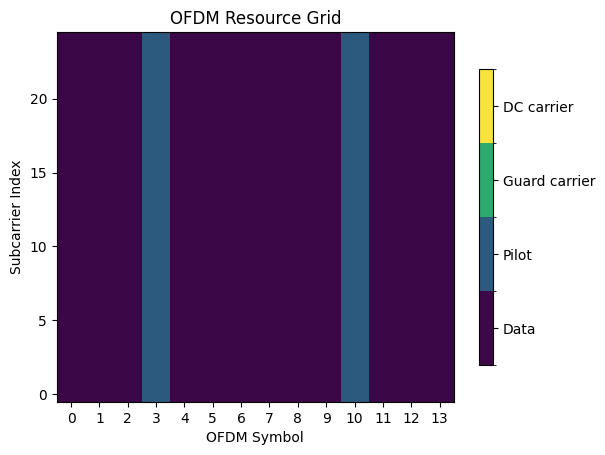

In [4]:
RESOURCE_GRID = sionna.phy.ofdm.ResourceGrid(num_ofdm_symbols=14,
                                         fft_size=25,
                                         subcarrier_spacing=30e3,
                                         num_tx=NUM_UT,
                                         num_streams_per_tx=NUM_STREAMS_PER_TX,
                                         cyclic_prefix_length=0,
                                         pilot_pattern="kronecker",
                                         pilot_ofdm_symbol_indices=[3,10])
RESOURCE_GRID.show();

In [5]:
awgn_channel = AWGN()
binary_source = sionna.phy.mapping.BinarySource()

# Create a BPSK constellation with 1 bit per symbol and specify the initial values
constellation = sionna.phy.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL)

# The mapper maps blocks of information bits to constellation symbols
mapper = sionna.phy.mapping.Mapper("qam", NUM_BITS_PER_SYMBOL)

# The resource grid mapper maps symbols onto an OFDM resource grid
rg_mapper = sionna.phy.ofdm.ResourceGridMapper(RESOURCE_GRID)

# The LS channel estimator will provide channel estimates and error variances
ls_est = sionna.phy.ofdm.LSChannelEstimator(RESOURCE_GRID, interpolation_type="nn")

# The LMMSE equalizer will provide soft symbols together with noise variance estimates
lmmse_equ = sionna.phy.ofdm.LMMSEEqualizer(RESOURCE_GRID, STREAM_MANAGEMENT)

# The demapper produces LLR for all coded bits
demapper = sionna.phy.mapping.Demapper("app", "qam", NUM_BITS_PER_SYMBOL, hard_out = True)

#encoder = sionna.fec.conv.ConvEncoder() # constraint length of the code
#decoder = sionna.fec.conv.ViterbiDecoder() # the code parameters are infered from the encoder

#mapper_1 = sionna.mapping.Mapper(constellation=constellation)
# The demapper uses the same constellation object as the mapper
#demapper_1 = sionna.mapping.Demapper("app", constellation=constellation)

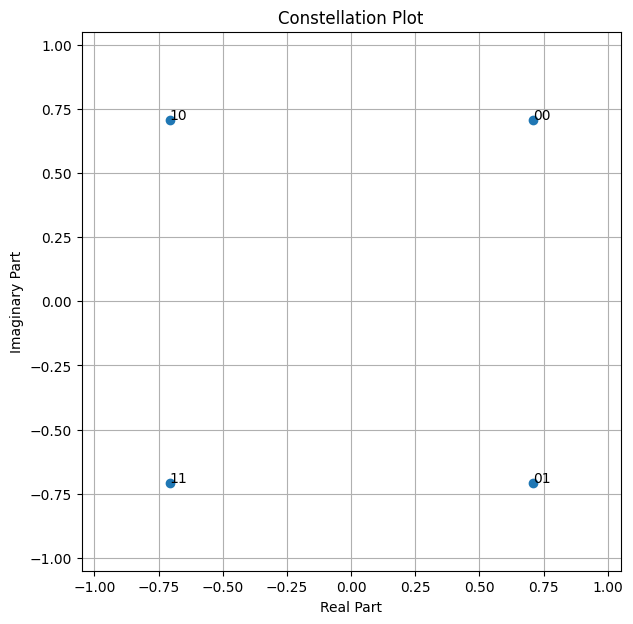

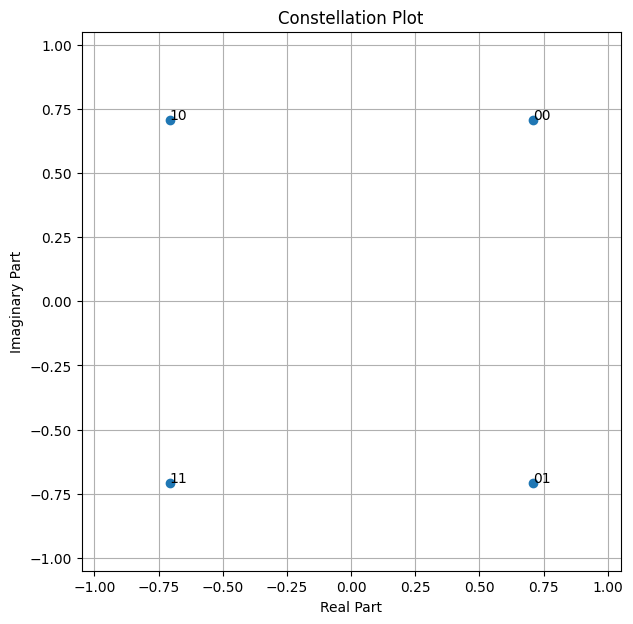

In [6]:
# You can visualize the constellation if needed
constellation.show()

In [7]:
bits = binary_source([BATCH_SIZE, NUM_UT, NUM_STREAMS_PER_TX , k])
print(bits.shape)

# The mapper maps blocks of information bits to constellation symbols
x = mapper(bits)
print(x.shape)

no = sionna.phy.utils.ebnodb2no(ebno_db=7.0,
                        num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                        coderate=CODERATE)
print(no)

x_rg = rg_mapper(x)
print("Shape of x_rg (mapping in Resource Grid): ", x_rg.shape)
# x is the channel input
# no is the noise variance
y = awgn_channel(x, no)
y_2 = awgn_channel(x_rg, no)
print(y_2.shape)

# The demapper produces LLR for all coded bits
bits_hat = demapper(y , no)
print(bits_hat.shape)

(100, 1, 1, 600)
(100, 1, 1, 300)
tf.Tensor(0.09976312, shape=(), dtype=float32)
Shape of x_rg (mapping in Resource Grid):  (100, 1, 1, 14, 25)
(100, 1, 1, 14, 25)
(100, 1, 1, 600)


In [8]:
num_samples = 20 # how many samples shall be printed
num_symbols = int(num_samples/NUM_BITS_PER_SYMBOL)

print(f"First {num_samples} transmitted bits: {bits[0,0,0,:num_samples]}")
print(f"First {num_symbols} transmitted symbols: {np.round(x[0,0,0,:num_symbols], 2)}")
print(f"First {num_symbols} received symbols: {np.round(y[0,0,0,:num_symbols], 2)}")
print(f"First {num_samples} demapped llrs: {np.round(bits_hat[0,0,0,:num_samples], 2)}")
#print(f"First {num_samples} Received symbols: {np.round(bits_hat[0,0,0,:num_samples], 2)}")

First 20 transmitted bits: [0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.]
First 10 transmitted symbols: [ 0.71-0.71j  0.71-0.71j -0.71-0.71j  0.71-0.71j  0.71-0.71j  0.71+0.71j
  0.71+0.71j  0.71-0.71j -0.71+0.71j  0.71+0.71j]
First 10 received symbols: [ 0.71-0.62j  0.41-0.83j -0.32-0.37j  0.72-0.77j  0.52-0.44j  0.26+0.37j
  0.47+0.76j  0.61-0.78j -0.7 +0.68j  0.85+0.53j]
First 20 demapped llrs: [0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.]


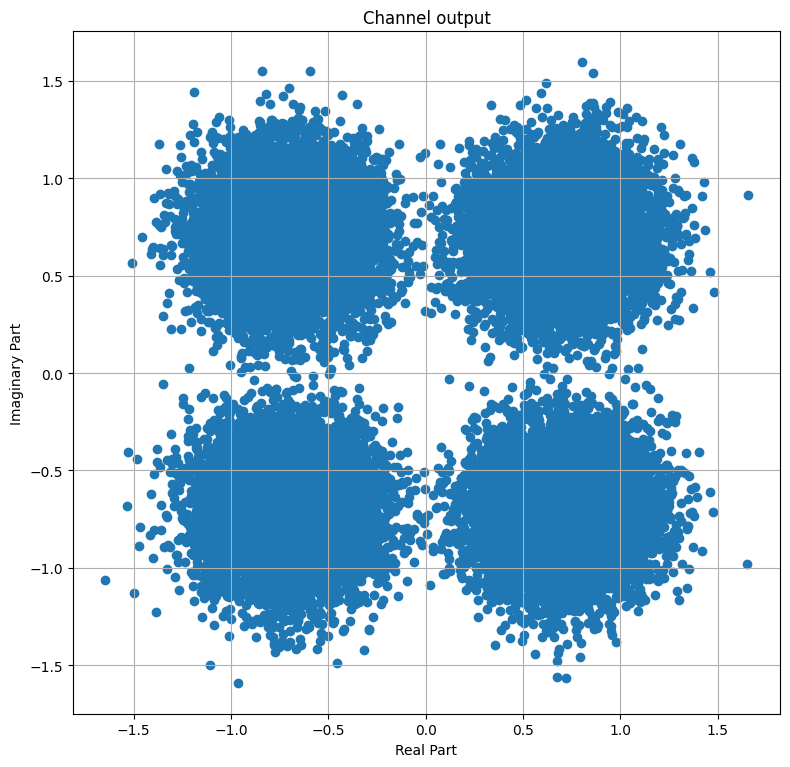

In [9]:
plt.figure(figsize=(8,8))
plt.axes().set_aspect(1)
plt.grid(True)
plt.title('Channel output')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.scatter(tf.math.real(y), tf.math.imag(y))
plt.tight_layout()

SNR(dB): -3, BER: 0.15813
SNR(dB): -2, BER: 0.13115
SNR(dB): -1, BER: 0.10267
SNR(dB): 0, BER: 0.07815
SNR(dB): 1, BER: 0.05710
SNR(dB): 2, BER: 0.03847
SNR(dB): 3, BER: 0.02390
SNR(dB): 4, BER: 0.01317
SNR(dB): 5, BER: 0.00625
SNR(dB): 6, BER: 0.00237
SNR(dB): 7, BER: 0.00095
SNR(dB): 8, BER: 0.00020
SNR(dB): 9, BER: 0.00000
x_rg shape: (100, 1, 1, 14, 25)
Shape of y_rg:  (100, 1, 1, 14, 25)
Shape of h_hat:  (100, 1, 1, 1, 1, 14, 25)
Shape of err_var:  (1, 1, 1, 1, 1, 14, 25)
Shape of x_hat:  (100, 1, 1, 300)
Shape of no_eff:  (100, 1, 1, 300)
Shape of llr:  (100, 1, 1, 600)
1
SNR(dB): -3, BER: 0.26683
x_rg shape: (100, 1, 1, 14, 25)
Shape of y_rg:  (100, 1, 1, 14, 25)
Shape of h_hat:  (100, 1, 1, 1, 1, 14, 25)
Shape of err_var:  (1, 1, 1, 1, 1, 14, 25)
Shape of x_hat:  (100, 1, 1, 300)
Shape of no_eff:  (100, 1, 1, 300)
Shape of llr:  (100, 1, 1, 600)
1
SNR(dB): -2, BER: 0.23123
x_rg shape: (100, 1, 1, 14, 25)
Shape of y_rg:  (100, 1, 1, 14, 25)
Shape of h_hat:  (100, 1, 1, 1, 1, 14,

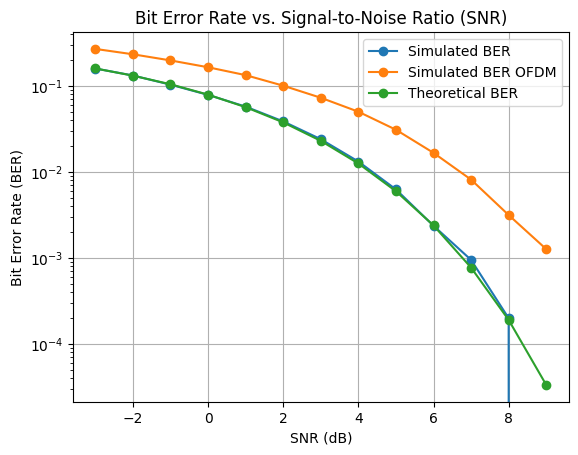

In [11]:
from scipy import stats

# Define the range of SNRs
snr_range_db = np.arange(-3, 10)  # Range from -3 dB to 10 dB

# Placeholder to store BER values
ber_values = []

for ebno_db in snr_range_db:
    # Convert dB to noise power ratio
    no = sionna.phy.utils.ebnodb2no(ebno_db,
                                num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                                coderate=CODERATE)

    # Transmitter
    y = awgn_channel(x, no)  # Simulate channel output
    bits_hat = demapper(y , no)
    ber = compute_ber(bits, bits_hat).numpy()
    print(f"SNR(dB): {ebno_db}, BER: {ber:.5f}")
    ber_values.append(ber)

    
# Define the range of SNRs
snr_range_db = np.arange(-3, 10)  # Range from -3 dB to 10 dB

#  OFDM Simulation Loop
ber_values_ofdm = []

for ebno_db in snr_range_db:
    no = sionna.phy.utils.ebnodb2no(ebno_db,
                                num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                                coderate=CODERATE)
    
    # Transmitter
    x_rg = rg_mapper(x)  # Ensure x_flattened matches ResourceGrid
    print("x_rg shape:", x_rg.shape)
    
    # Channel
    y_3 = awgn_channel(x_rg, no)
    print("Shape of y_rg: ", y_3.shape)

    
    # Receiver
    
    h_hat, err_var = ls_est (y_3, no)
    print("Shape of h_hat: ", h_hat.shape)
    print("Shape of err_var: ", err_var.shape)
    x_hat, no_eff = lmmse_equ(y_3, h_hat, err_var, no)
    print("Shape of x_hat: ", x_hat.shape)
    print("Shape of no_eff: ", no_eff.shape)
    llr = demapper(x_hat, no_eff)
    print("Shape of llr: ", llr.shape)

    ber = compute_ber(bits, llr).numpy()
    print(1)
    print(f"SNR(dB): {ebno_db}, BER: {ber:.5f}")
    ber_values_ofdm.append(ber)
    
# Calculate theoretical BER
SNR = 10 ** (snr_range_db / 10)
BER_th = stats.norm.sf(np.sqrt(2 * SNR))
print(BER_th.shape)

print("snr_range_db length:", len(snr_range_db))
print("ber_values length:", len(ber_values))
print("ber_values_ofdm length:", len(ber_values_ofdm))

# Plot BER curves
plt.figure()
plt.semilogy(snr_range_db, ber_values, marker='o', label='Simulated BER')
plt.semilogy(snr_range_db, ber_values_ofdm, marker='o', label='Simulated BER OFDM')
plt.semilogy(snr_range_db, BER_th, marker='o', label='Theoretical BER')
plt.xlabel('SNR (dB)')
plt.ylabel('Bit Error Rate (BER)')
plt.title('Bit Error Rate vs. Signal-to-Noise Ratio (SNR)')
plt.grid(True)
plt.legend()
plt.show()

In [63]:
import tensorflow as tf
import numpy as np
import sionna
from sionna.ofdm import ResourceGrid, OFDMModulator, OFDMDemodulator
from sionna.mapping import Mapper, Demapper
from sionna.channel import RayleighBlockFading

# Define OFDM system parameters
num_subcarriers = 64
num_symbols = 14  # OFDM symbols per frame
num_tx_antennas = 1
num_rx_antennas = 1

# Create an OFDM resource grid
rg = ResourceGrid(num_subcarriers=num_subcarriers, num_ofdm_symbols=num_symbols)

# Define a 16-QAM Mapper
mapper = Mapper(constellation="qam", num_bits_per_symbol=4)

# Generate random bit sequence
batch_size = 1
num_bits = rg.num_data_symbols * mapper.num_bits_per_symbol
tx_bits = tf.random.uniform([batch_size, num_bits], minval=0, maxval=2, dtype=tf.int32)

# Map bits to symbols
tx_symbols = mapper(tx_bits)

# Apply OFDM Modulation
modulator = OFDMModulator(rg)
tx_ofdm_signal = modulator(tx_symbols)

# Simulate a Rayleigh fading channel
channel = RayleighBlockFading(num_tx_antennas=num_tx_antennas, num_rx_antennas=num_rx_antennas)
rx_ofdm_signal = channel(tx_ofdm_signal)

# Apply OFDM Demodulation
demodulator = OFDMDemodulator(rg)
rx_symbols = demodulator(rx_ofdm_signal)

# Apply Demapping (Convert received symbols back to bits)
demapper = Demapper(constellation="qam", num_bits_per_symbol=4)
rx_bits = demapper(rx_symbols)

# Compute Bit Error Rate (BER)
ber = tf.reduce_mean(tf.cast(tf.not_equal(tx_bits, rx_bits), tf.float32))

print(f"Bit Error Rate (BER): {ber.numpy():.5f}")

ModuleNotFoundError: No module named 'sionna.ofdm'